This extensive example is based on the data by Roelant et al.
First load all data

In [4]:
from __future__ import annotations

from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from scipy.optimize import minimize, Bounds
from delayed_reactant_labeling.optimize import RateConstantOptimizerTemplate
from delayed_reactant_labeling.predict import DRL

Plot the data. Change the xlim to see the entire spectrum.

Text(0.5, 0, 'time (min)')

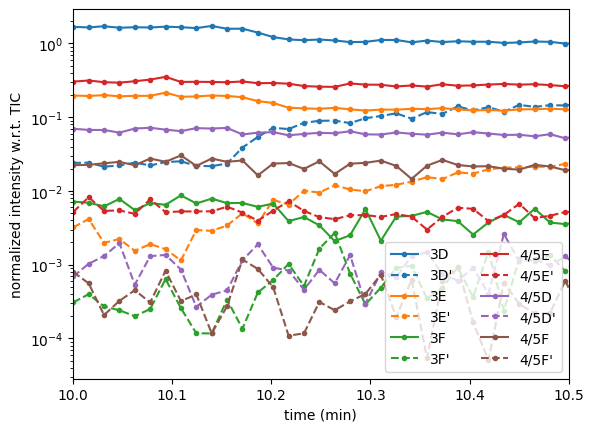

In [5]:
experimental_complete = pd.read_excel('experimental_data_Roelant.xlsx', engine='openpyxl')
LABEL = "'"  # single ' will was used for labeled reactants. To keep the code general, we will use LABEL instead.

fig, ax = plt.subplots()
n = 0
for col in experimental_complete.columns:
    if col == 'time (min)' or col[-len(LABEL):] == LABEL:
        continue
    ax.plot(experimental_complete['time (min)'], experimental_complete[col], linestyle='-', marker='.', label=col, color=f'C{n}')
    ax.plot(experimental_complete['time (min)'], experimental_complete[f'{col}{LABEL}'], linestyle='--', marker='.', label=f'{col}{LABEL}', color=f'C{n}')
    n += 1

ax.legend(ncol=2)
ax.set_ylabel('normalized intensity w.r.t. TIC')
ax.set_xlim(10, 10.5)
ax.set_yscale('log')
ax.set_xlabel('time (min)')

At 10.15 min, we clearly see the spectrum change. So let us use this as our t0.
Furthermore we see that the labeled chemicals have values before the addition of the labeled chemical, which is due to noise.
If we assume that this noise is static and doesnt change over the course of the measurment we can correct for it.

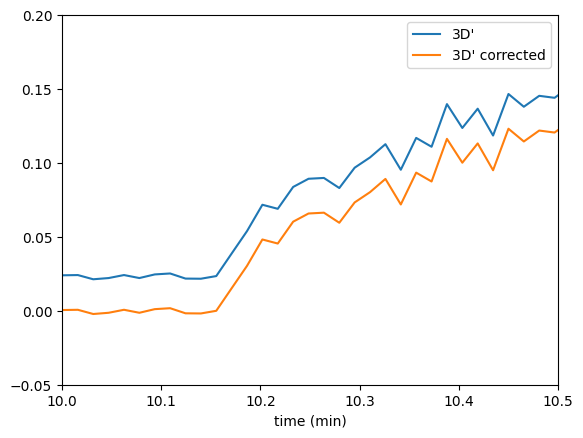

In [6]:
ax = experimental_complete.plot('time (min)', f'3D{LABEL}')

TIME_LABELED_ADDITION = 10.15
index_labeled_addition = np.argmax(experimental_complete['time (min)'] > TIME_LABELED_ADDITION)  # select first true value
for col in experimental_complete.columns:
    if col == 'time (min)' or col[-len(LABEL):] != LABEL:
        continue
    experimental_complete.loc[:, col] = experimental_complete.loc[:, col] \
        - experimental_complete.loc[index_labeled_addition-10:index_labeled_addition, col].median()

experimental_complete.plot('time (min)', f'3D{LABEL}', ax=ax, label=f'3D{LABEL} corrected')  # if only one line is shown, make sure to run the cell above beforehand!
ax.set_xlim(10, 10.5)
ax.set_ylim(-0.05, 0.2)

time_pre = experimental_complete.loc[:index_labeled_addition, 'time (min)'].to_numpy()  # pre addition
experimental = experimental_complete.loc[index_labeled_addition:, :]
time = experimental['time (min)'].to_numpy()

In [7]:
ax.figure.show()

C:\Users\mdingemans\AppData\Local\Temp\ipykernel_9900\1000995512.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax.figure.show()


## METRIC to analyze the errors

C:\Users\mdingemans\AppData\Local\Temp\ipykernel_9900\3800523221.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


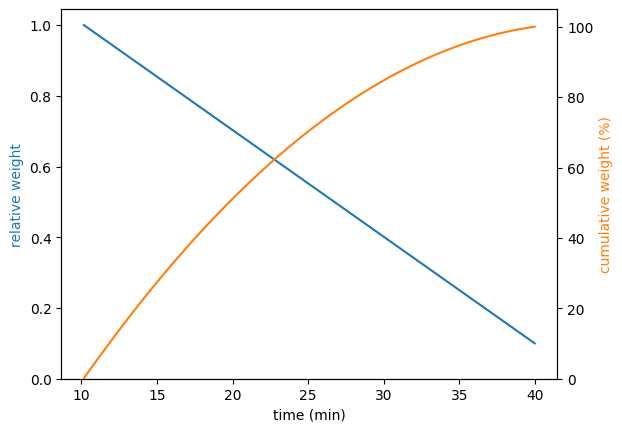

In [8]:
WEIGHT_TIME = 1 - 0.9 * np.linspace(0, 1, time.shape[0])  # decrease weight with time, first point 10 times as import as last point
WEIGHT_TIME = WEIGHT_TIME / sum(WEIGHT_TIME)  # normalize

def METRIC(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.average(np.abs(y_pred - y_true), weights=WEIGHT_TIME, axis=0)

fig, ax = plt.subplots()
ax.set_xlabel('time (min)')
ax.plot(time, WEIGHT_TIME / max(WEIGHT_TIME), color='C0')
ax.set_ylabel('relative weight', color='C0')
ax.set_ylim(bottom=0)
ax2 = ax.twinx()
ax2.plot(time, WEIGHT_TIME.cumsum() * 100, color='C1')
ax2.set_ylabel('cumulative weight (%)', color='C1')
ax2.set_ylim(bottom=0)
fig.show()

## utilize normal kinetics

3F Desired error not necessarily achieved due to precision loss.


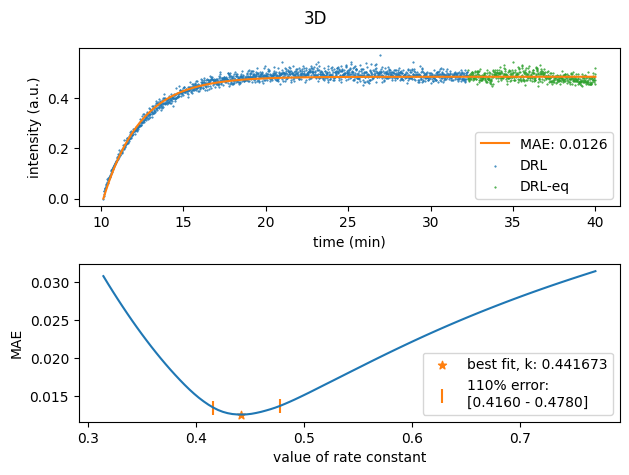

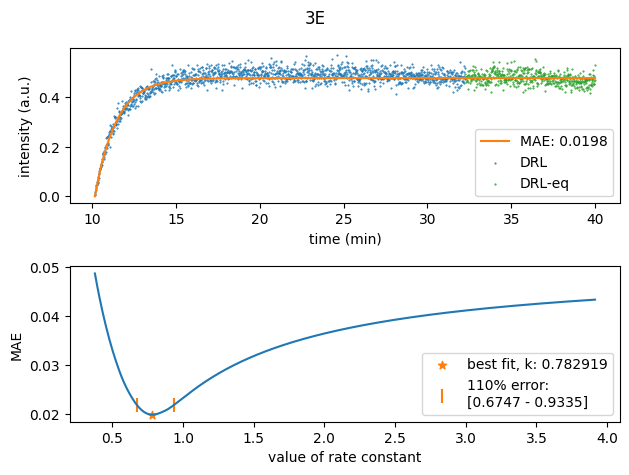

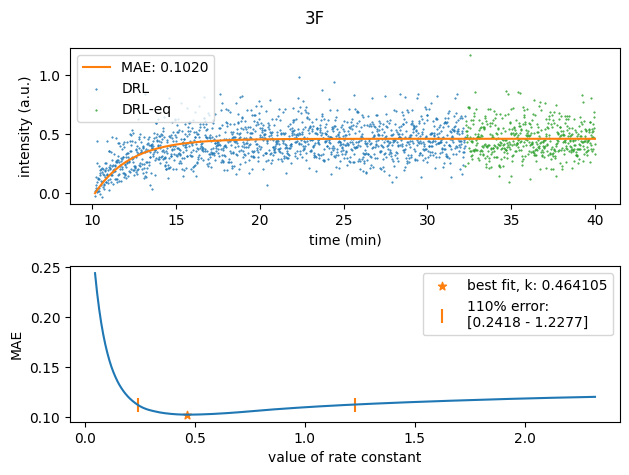

In [9]:
STEADY_STATE_CHEMICALS = ['3D', '3E', '3F']
EQUILIBRIUM_LAST_N = 500

for chemical in STEADY_STATE_CHEMICALS:
    # normalize for each steady state such that chemical + chemical' = 1 at equilibrium
    y_true_curve = experimental[f'{chemical}{LABEL}'] / experimental.loc[-EQUILIBRIUM_LAST_N:, [chemical, f'{chemical}{LABEL}']].sum(axis=1).mean()
    f = lambda k: y_true_curve.iloc[-EQUILIBRIUM_LAST_N:].mean() * (1 - np.exp( -k * (time - time[0])))
    MAE_f = lambda x: METRIC(y_true=y_true_curve, y_pred=f(x))

    result = minimize(MAE_f, x0=np.array([1]))
    if not result.success: print(chemical, result.message)

    # show best fit
    fig, axs = plt.subplots(2, 1, layout='tight')
    fig.suptitle(chemical)
    ax = axs[0]
    ax.plot(time, f(result.x[0]), label=f'MAE: {result.fun:.4f}', color='tab:orange')
    ax.scatter(time[:-EQUILIBRIUM_LAST_N], y_true_curve[:-EQUILIBRIUM_LAST_N],s=1, marker='.', color='tab:blue', label='DRL')
    ax.scatter(time[-EQUILIBRIUM_LAST_N:], y_true_curve[-EQUILIBRIUM_LAST_N:],s=1, marker='.', color='tab:green', label='DRL-eq')
    ax.set_xlabel('time (min)')
    ax.set_ylabel('intensity (a.u.)')
    ax.legend()

    # analyze sensitivity to deviations
    rates = np.linspace(0, 5*result.x[0], num=500)
    errors = np.array([MAE_f(x) for x in rates])
    ind = errors < 2.5*result.fun
    ax = axs[1]
    ax.plot(rates[ind], errors[ind])
    ax.scatter(result.x[0], result.fun, label=f'best fit, k: {result.x[0]:.6f}', marker='*', color='tab:orange')
    bounds_10pc = np.where(errors<1.1*result.fun)[0][[0, -1]]
    ax.scatter(rates[bounds_10pc], errors[bounds_10pc], marker='|', color='tab:orange', s=100,
               label=f'110% error:\n[{rates[bounds_10pc[0]]:.4f} - {rates[bounds_10pc[1]]:.4f}]')
    ax.set_xlabel('value of rate constant')
    ax.set_ylabel('MAE')
    ax.legend()

## The Chemical System

In [10]:
REACTIONS_ONEWAY = []
for label in ["", LABEL]:
    REACTIONS_ONEWAY.extend([
        ("k1_D", ["cat", f"2{label}", ], [f"3D{label}", ]),
        ("k1_E", ["cat", f"2{label}", ], [f"3E{label}", ]),
        ("k1_F", ["cat", f"2{label}", ], [f"3F{label}", ]),

        ("k2_D", [f"3D{label}", ], [f"4D{label}", ]),
        ("k2_E", [f"3E{label}", ], [f"4E{label}", ]),
        ("k2_F", [f"3F{label}", ], [f"4F{label}", ]),

        ("k3_D", [f"4D{label}", ], [f"5D{label}", ]),
        ("k3_E", [f"4E{label}", ], [f"5E{label}", ]),
        ("k3_F", [f"4F{label}", ], [f"5F{label}", ]),

        ("k4_D", [f"5D{label}", ], [f"6D{label}", "cat", ]),
        ("k4_E", [f"5E{label}", ], [f"6E{label}", "cat", ]),
        ("k4_F", [f"5F{label}", ], [f"6F{label}", "cat", ]),
    ])

reactions = deepcopy(REACTIONS_ONEWAY)
for k, reactants, products in REACTIONS_ONEWAY:
    reactions.append(("k-" + k[1:], products, reactants))
rate_constant_names = sorted(set([k for k, _, _ in reactions]))

# these groups will make the analysis easier
ISOMERS = ["D", "E", "F"]
INTERMEDIATES = ["3", "4/5"]

## RCO

In [11]:
WEIGHTS = {
    "label_": 1,
    "isomer_": 0.5,
    "TIC": 0.2,
    "iso_F": 0.25,
}
# By putting it outside the function, we can store in the metadata of each optimization process.
CONCENTRATIONS_INITIAL = {"cat": 0.005 * 40 / 1200,  # concentration in M
                          "2": 0.005 * 800 / 1200}
CONCENTRATION_LABELED_REACTANT = {"2'": 0.005 * 800 / 2000}
DILUTION_FACTOR = 1200 / 2000

class RateConstantOptimizer(RateConstantOptimizerTemplate):
    @staticmethod
    def create_prediction(x: np.ndarray, x_description: list[str]) -> pd.DataFrame:
        # separate out the ionization factor from the other parameters which are being optimized.
        rate_constants = pd.Series(x[:len(rate_constant_names)], index=x_description[:len(rate_constant_names)])
        ionization_factor = x[-1]

        drl = DRL(reactions=reactions,
                  rate_constants=rate_constants,
                  verbose=False)

        prediction_labeled = drl.predict_concentration(
            t_eval_pre=time_pre,
            t_eval_post=time,
            initial_concentrations=CONCENTRATIONS_INITIAL,
            labeled_concentration=CONCENTRATION_LABELED_REACTANT,
            dilution_factor=DILUTION_FACTOR,
            rtol=1e-8,
            atol=1e-8)

        # SYSTEM-SPECIFIC ENAMINE IONIZATION CORRECTION -> only a prediction of 4/5 can be made!
        for isomer in ISOMERS:
            for label in ["", "'"]:
                prediction_labeled.loc[:, f"4/5{isomer}{label}"] = prediction_labeled.loc[:, f"5{isomer}{label}"] \
                    + ionization_factor * prediction_labeled.loc[:, f"4{isomer}{label}"]

        return prediction_labeled

    @staticmethod
    def calculate_curves(data: pd.DataFrame) -> dict[str, np.ndarray]:
        curves = {}
        for intermediate in INTERMEDIATES:
            # sum does not have to be recalculated between the isomer runs
            sum_all_isomers = data[[f'{intermediate}{isomer}' for isomer in ISOMERS]].sum(axis=1)
            for isomer in ISOMERS:
                chemical = f"{intermediate}{isomer}"  # 3D, 3E, 3F, 4/5D, 4/5E, 3/5F
                chemical_iso_split = f"int_{intermediate}_iso_{isomer}"  # allows for easy modification of weight. str.contains('int_1') is much more specific than just '1'

                sum_chemical = data[[chemical, f"{chemical}'"]].sum(axis=1)

                curves[f"label_{chemical_iso_split}"] = (  # 3D / (3D+3D')
                    data[chemical] / sum_chemical).to_numpy()
                curves[f"isomer_{chemical_iso_split}"] = (  # 3D / (3D+3E+3F)
                    data[chemical] / sum_all_isomers).to_numpy()
                curves[f"TIC_{chemical_iso_split}"] = (  # normalized TIC curve
                        data[chemical] / sum_chemical.iloc[-100:].mean()).to_numpy()
                curves[f"TIC_{chemical_iso_split}'"] = (  # normalized TIC curve
                        data[f"{chemical}'"] / sum_chemical.iloc[-100:].mean()).to_numpy()
        return curves

    def weigh_errors(self, errors: pd.Series) -> pd.Series:
        weighed_errors = super().weigh_errors(errors)

        # perform the usual behavior of this function, but also perform an additional check with regards to the output.
        TIC_sum = weighed_errors[weighed_errors.index.str.contains("TIC_")].sum()
        label_sum = weighed_errors[weighed_errors.index.str.contains("label_")].sum()
        isomer_sum = weighed_errors[weighed_errors.index.str.contains("isomer_")].sum()
        total = TIC_sum + label_sum + isomer_sum
        ratios = pd.Series([TIC_sum/total, label_sum/total, isomer_sum/total], index=['TIC', 'label', 'total'])
        if any(ratios < 0.05) or any(ratios > 0.95):
            warnings.warn(f'One of the error metrics is either way smaller, or way larger than the others\n{ratios}')

        return weighed_errors


RCO = RateConstantOptimizer(experimental=experimental, metric=METRIC, raw_weights=WEIGHTS)

In [12]:
dimension_descriptions = list(rate_constant_names) + ["ion"]
constraints = pd.DataFrame(np.full((len(dimension_descriptions), 3), np.nan),
                           columns=["vertex", "lower", "upper"],
                           index=dimension_descriptions)

index_reverse_reaction = constraints.index.str.contains("k-")
constraints[~index_reverse_reaction] = [1, 1e-9, 1e3]  # forwards; vertex, lb, ub
constraints[index_reverse_reaction] = [0.5, 0, 1e2]    # backwards

# special case
constraints[constraints.index.str.contains("ion")] = [0.01, 1e-6, 1]

constraints[constraints.index.str.contains("k2_D")] = [0.410972, 0.3789, 0.4530]
constraints[constraints.index.str.contains("k2_E")] = [0.644027, 0.5227, 0.8002]
constraints[constraints.index.str.contains("k2_F")] = [0.510573, 0.2763, 1.1920]

# either chemically or experimentally determined to be zero
constraints[constraints.index.str.contains("k-1")] = [0, 0, 0]
constraints[constraints.index.str.contains("k-3")] = [0, 0, 0]
constraints[constraints.index.str.contains("k-4")] = [0, 0, 0]
vertex = constraints["vertex"].to_numpy()
bounds = Bounds(constraints['lower'].to_numpy(), constraints['upper'].to_numpy())

# the values which will remain constant. This is used mainly for visualization purposes.
index_constant_values = np.array([
    constraints.index.str.contains("k-1_"),
    constraints.index.str.contains("k-3_"),
    constraints.index.str.contains("k-4_")
]).any(axis=0)

In [ ]:
path = 'optimization/'
RCO.optimize(
    x0=vertex,
    x_description=dimension_descriptions,
    x_bounds=bounds,
    path=path,
    maxiter=50000,
    _overwrite_log=True
)

 68%|██████▊   | 34250/50000 [17:15<07:55, 33.10it/s]

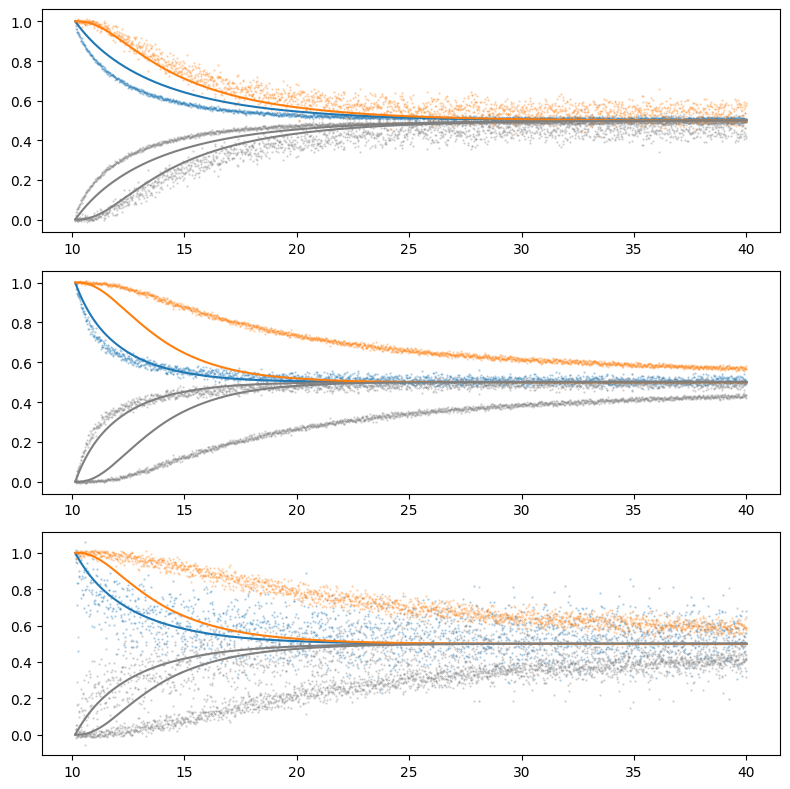

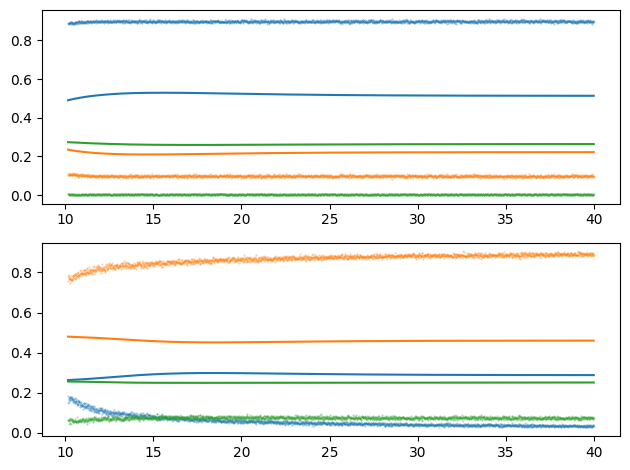

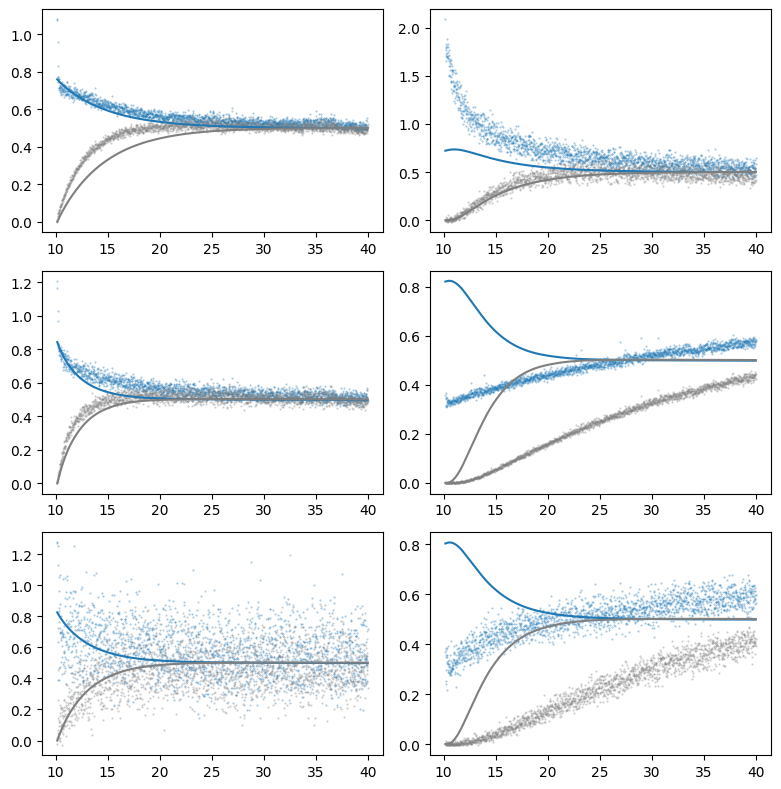

In [14]:
fig_label, axs_label = plt.subplots(3, 1, tight_layout=True, figsize=(8, 8), squeeze=False)
fig_isomer, axs_isomer = plt.subplots(2, 1, tight_layout=True, squeeze=False)
fig_TIC, axs_TIC = plt.subplots(3, 2, tight_layout=True, figsize=(8, 8), squeeze=False)
marker_settings = {"alpha": 0.4, "marker": ".", "s": 1}

progress = RCO.load_optimization_progress(path)

best_prediction: pd.DataFrame = RCO.create_prediction(progress.best_X, progress.x_description)

true = RCO.experimental_curves
pred = RCO.calculate_curves(best_prediction)

errors = RCO.weigh_errors(RCO.calculate_errors(best_prediction))

for i, intermediate in enumerate(INTERMEDIATES):
    # sum does not have to be recalculated between the isomer runs
    sum_all_isomers = best_prediction[[intermediate+isomer for isomer in ISOMERS]].sum(axis=1)
    for j, isomer in enumerate(ISOMERS):
        # the "iso_" prefix is given to each chemical so that we can search the strings for e.g. "iso_A" and not get a match for label
        chemical_iso_split = f"int_{intermediate}_iso_{isomer}"

        # plot label ratio
        axs_label[j, 0].plot(time, pred[f"label_{chemical_iso_split}"], color=f"C{i}", label=f"{chemical_iso_split} MAE: {errors[f'label_{chemical_iso_split}']:.3f}")
        axs_label[j, 0].scatter(time, true[f"label_{chemical_iso_split}"], color=f"C{i}", **marker_settings)
        # the curve of the labeled compound is the same, by definition, as 1 - unlabeled
        axs_label[j, 0].plot(time, 1-pred[f"label_{chemical_iso_split}"], color="tab:gray")
        axs_label[j, 0].scatter(time, 1-true[f"label_{chemical_iso_split}"], color="tab:gray", **marker_settings)

        # isomer ratio
        axs_isomer[i, 0].plot(time, pred[f"isomer_{chemical_iso_split}"], label=f"{chemical_iso_split} MAE: {errors[f'isomer_{chemical_iso_split}']:.3f}")
        axs_isomer[i, 0].scatter(time, RCO.experimental_curves[f"isomer_{chemical_iso_split}"], **marker_settings)

        # TIC shape
        axs_TIC[j, i].plot(time, pred[f"TIC_{chemical_iso_split}"],
                           color="tab:blue", label=f"{chemical_iso_split} MAE: {errors[f'TIC_{chemical_iso_split}']:.3f}")
        axs_TIC[j, i].scatter(time, RCO.experimental_curves[f"TIC_{chemical_iso_split}"], color="tab:blue", **marker_settings)

        axs_TIC[j, i].plot(time, pred[f"TIC_{chemical_iso_split}'"],
                           color="tab:gray", label=f"""{chemical_iso_split} MAE: {errors[f"TIC_{chemical_iso_split}'"]:.3f}""")
        axs_TIC[j, i].scatter(time, RCO.experimental_curves[f"TIC_{chemical_iso_split}'"], color="tab:gray", **marker_settings)

In [166]:
RCO.optimize_multiple(
    path='./optimization_multiple/',
    n_runs=42,
    x_description=dimension_descriptions,
    x_bounds=bounds,
    maxiter=200,
    n_jobs=-2,
)

C:\Users\mdingemans\delayed_reactant_labeling\src\delayed_reactant_labeling\optimize.py:421: UserWarning: Cannot create a directory when that directory already exists. Appending results instead starting with seed 2
  warnings.warn("Cannot create a directory when that directory already exists. "


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-2)]: Done   2 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-2)]: Done   5 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-2)]: Done   6 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-2)]: Done   7 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-2)]: Done   8 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-2)]: Done   9 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-2)]: Done  13 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-2)]: Done  14 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-2)]: Done  15 tasks      | elapsed:   